# Raw NASDAQ LOBSTER Dataset Inspection

## 01. Imports & Global Config

This notebook provides: \
– Full raw-data coverage description \
– Event-based market microstructure statistics \
– Spread, liquidity, and event intensity measures \
– Asset-level comparability checks

All results are suitable for **Chapter 4.1** (Data Description).
No preprocessing, labeling, normalization, or modeling assumptions are applied.

In [2]:
import os
import re
import pandas as pd
import numpy as np
from collections import defaultdict
from datetime import timedelta

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

DATA_ROOT = "../data/NASDAQ"
TICKERS = sorted([d for d in os.listdir(DATA_ROOT) if os.path.isdir(os.path.join(DATA_ROOT, d))])

print("Detected tickers:", TICKERS)

Detected tickers: ['AAPL', 'CSCO', 'GOOG', 'INTC']


## 02. File Inventory & Temporal Coverage

In [3]:
print("="*80)
print("FILE INVENTORY & TEMPORAL COVERAGE")
print("="*80)

file_summary = []

pattern = re.compile(r".*_(\d{4}-\d{2}-\d{2})_.*_(message|orderbook)_10\.csv")

for ticker in TICKERS:
    files = os.listdir(os.path.join(DATA_ROOT, ticker))
    msg_files = sorted([f for f in files if "message" in f])
    lob_files = sorted([f for f in files if "orderbook" in f])

    dates = []
    for f in files:
        m = pattern.match(f)
        if m:
            dates.append(m.group(1))

    file_summary.append({
        "Ticker": ticker,
        "Message files": len(msg_files),
        "Orderbook files": len(lob_files),
        "Trading days": len(set(dates)),
        "First date": min(dates),
        "Last date": max(dates)
    })

df_files = pd.DataFrame(file_summary)
display(df_files)

FILE INVENTORY & TEMPORAL COVERAGE


,Ticker,Message files,Orderbook files,Trading days,First date,Last date
0,AAPL,20,20,20,2023-07-03,2023-07-31
1,CSCO,20,20,20,2023-07-03,2023-07-31
2,GOOG,20,20,20,2023-07-03,2023-07-31
3,INTC,20,20,20,2023-07-03,2023-07-31


## 03. Message File Schema & Event Types

In [4]:
print("=" * 80)
print("MESSAGE FILE STRUCTURE (DATA-DRIVEN INSPECTION)")
print("=" * 80)

# LOBSTER event type mapping (standard)
EVENT_TYPE_MAP = {
    1: "New limit order",
    2: "Partial cancellation",
    3: "Cancellation",
    4: "Execution",
    5: "Execution with price change"
}

for ticker in TICKERS:
    path = os.path.join(DATA_ROOT, ticker)
    msg_files = sorted([f for f in os.listdir(path) if "message" in f])
    
    if len(msg_files) == 0:
        print(f"\nTicker: {ticker} — No message files found.")
        continue

    # Load a small sample from the first trading day
    df = pd.read_csv(
        os.path.join(path, msg_files[0]),
        nrows=50,
        header=None
    )

    print(f"\nTicker: {ticker}")
    print("-" * 40)
    print("Sample shape:", df.shape)
    print("Number of columns:", df.shape[1])
    print("Column dtypes:")
    print(df.dtypes.to_string())

    # Event type inspection
    event_types = sorted(df[1].unique())
    print("\nObserved event types (sample):")
    for et in event_types:
        meaning = EVENT_TYPE_MAP.get(int(et), "Unknown")
        print(f"  {int(et)} → {meaning}")

MESSAGE FILE STRUCTURE (DATA-DRIVEN INSPECTION)

Ticker: AAPL
----------------------------------------
Sample shape: (50, 6)
Number of columns: 6
Column dtypes:
0    float64
1      int64
2      int64
3      int64
4      int64
5      int64

Observed event types (sample):
  1 → New limit order
  3 → Cancellation
  4 → Execution
  5 → Execution with price change

Ticker: CSCO
----------------------------------------
Sample shape: (50, 6)
Number of columns: 6
Column dtypes:
0    float64
1      int64
2      int64
3      int64
4      int64
5      int64

Observed event types (sample):
  1 → New limit order
  3 → Cancellation
  4 → Execution
  5 → Execution with price change

Ticker: GOOG
----------------------------------------
Sample shape: (50, 6)
Number of columns: 6
Column dtypes:
0    float64
1      int64
2      int64
3      int64
4      int64
5      int64

Observed event types (sample):
  1 → New limit order
  3 → Cancellation
  4 → Execution
  5 → Execution with price change

Ticker: I

## 04. Event Type Distribution (per Asset)

In [5]:
print("=" * 80)
print("EVENT TYPE DISTRIBUTIONS (RELATIVE FREQUENCIES)")
print("=" * 80)

# LOBSTER event type mapping (standard)
EVENT_TYPE_MAP = {
    1: "Limit order submission",
    2: "Cancellation",
    3: "Partial cancellation",
    4: "Execution",
    5: "Execution with price change",
    6: "Other / system event"
}

event_distributions = {}

for ticker in TICKERS:
    path = os.path.join(DATA_ROOT, ticker)
    msg_files = sorted([f for f in os.listdir(path) if "message" in f])

    counts = defaultdict(int)
    total_events = 0

    for f in msg_files:
        df = pd.read_csv(
            os.path.join(path, f),
            header=None,
            usecols=[1],
            names=["event_type"]
        )

        vc = df["event_type"].value_counts()
        for k, v in vc.items():
            counts[int(k)] += int(v)

        total_events += len(df)

    # Normalize to relative frequencies
    event_distributions[ticker] = {
        EVENT_TYPE_MAP.get(k, f"Unknown ({k})"): v / total_events
        for k, v in counts.items()
    }

# Build DataFrame
df_events = (
    pd.DataFrame(event_distributions)
    .fillna(0.0)
)

# Convert to percentages
df_events_pct = df_events * 100

# Enforce economically meaningful order
ORDER = [
    "Limit order submission",
    "Cancellation",
    "Partial cancellation",
    "Execution",
    "Execution with price change",
    "Other / system event"
]
df_events_pct = df_events_pct.loc[ORDER]

# Add liquidity-providing aggregate row
df_events_pct.loc["Liquidity-providing (LO submissions + cancellations = partial cancellations)"] = (
    df_events_pct.loc[
        ["Limit order submission", "Cancellation", "Partial cancellation"]
    ].sum()
)

# Add cross-asset average column (unweighted mean)
df_events_pct["Average"] = df_events_pct.mean(axis=1)

display(df_events_pct.round(2))

EVENT TYPE DISTRIBUTIONS (RELATIVE FREQUENCIES)


,AAPL,CSCO,GOOG,INTC,Average
Limit order submission,49.56,48.53,49.25,48.83,49.05
Cancellation,0.09,0.26,1.12,0.29,0.44
Partial cancellation,46.12,44.20,47.06,44.68,45.51
Execution,3.64,5.00,2.14,4.65,3.86
Execution with price change,0.59,2.00,0.43,1.55,1.14
Other / system event,0.00,0.00,0.00,0.00,0.00
Liquidity-providing (LO submissions + cancellations = partial cancellations),95.78,93.00,97.43,93.79,95.00


## 05. Orderbook Structure & Depth

In [5]:
print("=" * 80)
print("ORDERBOOK STRUCTURE & DEPTH (DATA-DRIVEN VALIDATION)")
print("=" * 80)

for ticker in TICKERS:
    path = os.path.join(DATA_ROOT, ticker)
    lob_file = sorted([f for f in os.listdir(path) if "orderbook" in f])[0]

    # Load small sample (structure only)
    df = pd.read_csv(os.path.join(path, lob_file), nrows=20, header=None)

    n_cols = df.shape[1]
    assert n_cols % 4 == 0, "Unexpected number of columns (not divisible by 4)"
    n_levels = n_cols // 4

    print(f"\nTicker: {ticker}")
    print("-" * 60)
    print(f"Total columns        : {n_cols}")
    print(f"Detected depth levels: {n_levels}")

    # --- Validate per-level structure ---
    structure_ok = True
    ask_prices = []
    bid_prices = []

    for lvl in range(n_levels):
        base = lvl * 4
        ask_p = df.iloc[:, base]
        ask_q = df.iloc[:, base + 1]
        bid_p = df.iloc[:, base + 2]
        bid_q = df.iloc[:, base + 3]

        # Basic sanity checks
        if not ((ask_q >= 0).all() and (bid_q >= 0).all()):
            structure_ok = False

        ask_prices.append(ask_p.mean())
        bid_prices.append(bid_p.mean())

    # --- Monotonicity checks across depth ---
    ask_monotone = all(ask_prices[i] <= ask_prices[i + 1] for i in range(len(ask_prices) - 1))
    bid_monotone = all(bid_prices[i] >= bid_prices[i + 1] for i in range(len(bid_prices) - 1))

    # --- Summary ---
    print("Structure validation :")
    print(f"  • Non-negative sizes        : {'OK' if structure_ok else 'FAIL'}")
    print(f"  • Ask prices increase depth : {'OK' if ask_monotone else 'FAIL'}")
    print(f"  • Bid prices decrease depth : {'OK' if bid_monotone else 'FAIL'}")

    if structure_ok and ask_monotone and bid_monotone:
        print("Inferred per-level structure:")
        print("  [AskPrice, AskSize, BidPrice, BidSize] (validated from data)")
    else:
        print("WARNING: Orderbook structure deviates from standard LOBSTER format")

ORDERBOOK STRUCTURE & DEPTH (DATA-DRIVEN VALIDATION)

Ticker: AAPL
------------------------------------------------------------
Total columns        : 40
Detected depth levels: 10
Structure validation :
  • Non-negative sizes        : OK
  • Ask prices increase depth : OK
  • Bid prices decrease depth : OK
Inferred per-level structure:
  [AskPrice, AskSize, BidPrice, BidSize] (validated from data)

Ticker: CSCO
------------------------------------------------------------
Total columns        : 40
Detected depth levels: 10
Structure validation :
  • Non-negative sizes        : OK
  • Ask prices increase depth : OK
  • Bid prices decrease depth : OK
Inferred per-level structure:
  [AskPrice, AskSize, BidPrice, BidSize] (validated from data)

Ticker: GOOG
------------------------------------------------------------
Total columns        : 40
Detected depth levels: 10
Structure validation :
  • Non-negative sizes        : OK
  • Ask prices increase depth : OK
  • Bid prices decrease depth :

## 06. Spread Statistics

SPREAD DISTRIBUTION (RELATIVE, BPS)


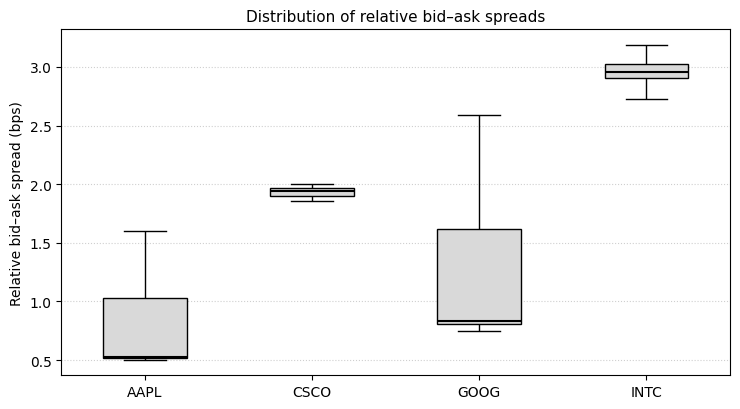

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("=" * 80)
print("SPREAD DISTRIBUTION (RELATIVE, BPS)")
print("=" * 80)

spread_data = []

for ticker in TICKERS:
    path = os.path.join(DATA_ROOT, ticker)
    lob_files = sorted([f for f in os.listdir(path) if "orderbook" in f])

    rel_spreads = []

    for f in lob_files:
        df = pd.read_csv(os.path.join(path, f), header=None)

        ask = df[0].values
        bid = df[2].values
        mid = 0.5 * (ask + bid)

        spread = ask - bid
        rel_spread_bps = (spread / mid) * 1e4  # basis points

        # drop invalid values
        rel_spread_bps = rel_spread_bps[np.isfinite(rel_spread_bps)]
        rel_spreads.extend(rel_spread_bps)

    spread_data.append(
        pd.DataFrame({
            "Ticker": ticker,
            "Relative spread (bps)": rel_spreads
        })
    )

spread_df = pd.concat(spread_data, ignore_index=True)

# Optional: robust trimming (recommended, matches your stats)
upper = spread_df["Relative spread (bps)"].quantile(0.99)
spread_df = spread_df[spread_df["Relative spread (bps)"] <= upper]

# Plot
plt.figure(figsize=(7.5, 4.2))

sns.boxplot(
    data=spread_df,
    x="Ticker",
    y="Relative spread (bps)",
    showfliers=False,
    width=0.5,
    boxprops=dict(facecolor="0.85", edgecolor="black"),
    medianprops=dict(color="black", linewidth=1.5),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black")
)

plt.ylabel("Relative bid–ask spread (bps)", fontsize=10)
plt.xlabel("")
plt.title("Distribution of relative bid–ask spreads", fontsize=11, pad=6)

plt.grid(axis="y", linestyle=":", linewidth=0.8, alpha=0.6)

grouped = spread_df.groupby("Ticker")["Relative spread (bps)"]
q3 = grouped.quantile(0.75)
medians = grouped.median()

plt.tight_layout()
plt.savefig("./spread_distribution.pdf")
plt.show()

## 07. Event Rate & Inter-Event Timing

In [8]:
print("="*80)
print("EVENT RATE & INTER-EVENT TIMES")
print("="*80)

timing_stats = []

for ticker in TICKERS:
    path = os.path.join(DATA_ROOT, ticker)
    msg_file = sorted([f for f in os.listdir(path) if "message" in f])[0]

    df = pd.read_csv(os.path.join(path, msg_file), header=None, usecols=[0])
    dt = df[0].diff().dropna()

    timing_stats.append({
        "Ticker": ticker,
        "Mean inter-event time (s)": dt.mean(),
        "Median inter-event time (s)": dt.median(),
        "Min inter-event time (s)": dt.min(),
        "Max inter-event time (s)": dt.max(),
        "Events per second": 1 / dt.mean()
    })

df_timing = pd.DataFrame(timing_stats)
display(df_timing)

EVENT RATE & INTER-EVENT TIMES


,Ticker,Mean inter-event time (s),Median inter-event time (s),Min inter-event time (s),Max inter-event time (s),Events per second
0,AAPL,0.010580,0.000109,0.0,1.571272,94.520726
1,CSCO,0.064737,0.000058,0.0,5.641896,15.447072
2,GOOG,0.010221,0.000150,0.0,3.028774,97.834209
3,INTC,0.037310,0.000049,0.0,4.922268,26.802429


## 08. Liquidity at Top of Book

In [11]:
print("="*80)
print("TOP-OF-BOOK LIQUIDITY")
print("="*80)

depth_stats = []

for ticker in TICKERS:
    path = os.path.join(DATA_ROOT, ticker)
    lob_file = sorted([f for f in os.listdir(path) if "orderbook" in f])[0]

    df = pd.read_csv(os.path.join(path, lob_file), header=None)

    ask_vol = df[1]
    bid_vol = df[3]

    depth_stats.append({
        "Ticker": ticker,
        "Mean ask size (L1)": ask_vol.mean(),
        "Mean bid size (L1)": bid_vol.mean(),
        "Median ask size": ask_vol.median(),
        "Median bid size": bid_vol.median()
    })

df_depth = pd.DataFrame(depth_stats)
display(df_depth)

TOP-OF-BOOK LIQUIDITY


,Ticker,Mean ask size (L1),Mean bid size (L1),Median ask size,Median bid size
0,AAPL,705.595125,592.408004,513.0,456.0
1,CSCO,2056.395106,1945.922655,1664.0,1637.0
2,GOOG,347.985838,392.479774,300.0,300.0
3,INTC,2474.748338,3076.262245,1840.0,2042.0


## Final Dataset Summary (4.1-ready Table)

In [23]:
print("="*80)
print("GLOBAL DATASET SUMMARY (CHAPTER 4.1)")
print("="*80)

df_summary = (
    df_files
    .merge(df_spread, on="Ticker")
    .merge(df_timing, on="Ticker")
    .merge(df_depth, on="Ticker")
)

display(df_summary)

GLOBAL DATASET SUMMARY (CHAPTER 4.1)


,Ticker,Message files,Orderbook files,Trading days,First date,Last date,Median spread (ticks),Mean spread (ticks),IQR spread (ticks),99% quantile (ticks),Median rel. spread (bps),Mean rel. spread (bps),Mean inter-event time (s),Median inter-event time (s),Min inter-event time (s),Max inter-event time (s),Events per second,Mean ask size (L1),Mean bid size (L1),Median ask size,Median bid size
0,AAPL,20,20,20,2023-07-03,2023-07-31,100.0,134.784917,100.0,300.0,0.524425,0.699618,0.010580,0.000109,0.0,1.571272,94.520726,705.595125,592.408004,513.0,456.0
1,CSCO,20,20,20,2023-07-03,2023-07-31,100.0,111.307460,0.0,200.0,1.941182,2.145746,0.064737,0.000058,0.0,5.641896,15.447072,2056.395106,1945.922655,1664.0,1637.0
2,GOOG,20,20,20,2023-07-03,2023-07-31,100.0,153.177635,100.0,400.0,0.836085,1.229456,0.010221,0.000150,0.0,3.028774,97.834209,347.985838,392.479774,300.0,300.0
3,INTC,20,20,20,2023-07-03,2023-07-31,100.0,112.958658,0.0,200.0,2.959893,3.326908,0.037310,0.000049,0.0,4.922268,26.802429,2474.748338,3076.262245,1840.0,2042.0
